In [ ]:
# !pip install Cython
# !pip install pomegranate
# !pip install pgmpy
# !pip install deap
# !pip install gmr
# !pip install pyvis

In [ ]:
import sys
sys.path.insert(0,'BAMT')

In [ ]:
from functools import partial
import itertools
import os
import os.path as osp

import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics, model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tqdm

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

In [ ]:
weather_data=pd.read_csv('weather_features.csv')
energy_data=pd.read_csv('energy_dataset.csv')

In [ ]:
weather_data_valencia = weather_data[weather_data['city_name'] == 'Valencia']

In [ ]:
valencia_energy_df = pd.concat([energy_data, weather_data_valencia], axis=1, join="inner")
# valencia_energy_df

In [ ]:
valencia_energy_df = valencia_energy_df[['generation fossil gas', 'generation fossil hard coal', 'total load actual', 'temp', 'temp_min', 'temp_max', 'price actual', 'price day ahead', 'generation wind onshore', 'generation waste', 'generation other renewable', 'generation fossil brown coal/lignite', 'generation biomass', 'humidity']]

In [ ]:
valencia_energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

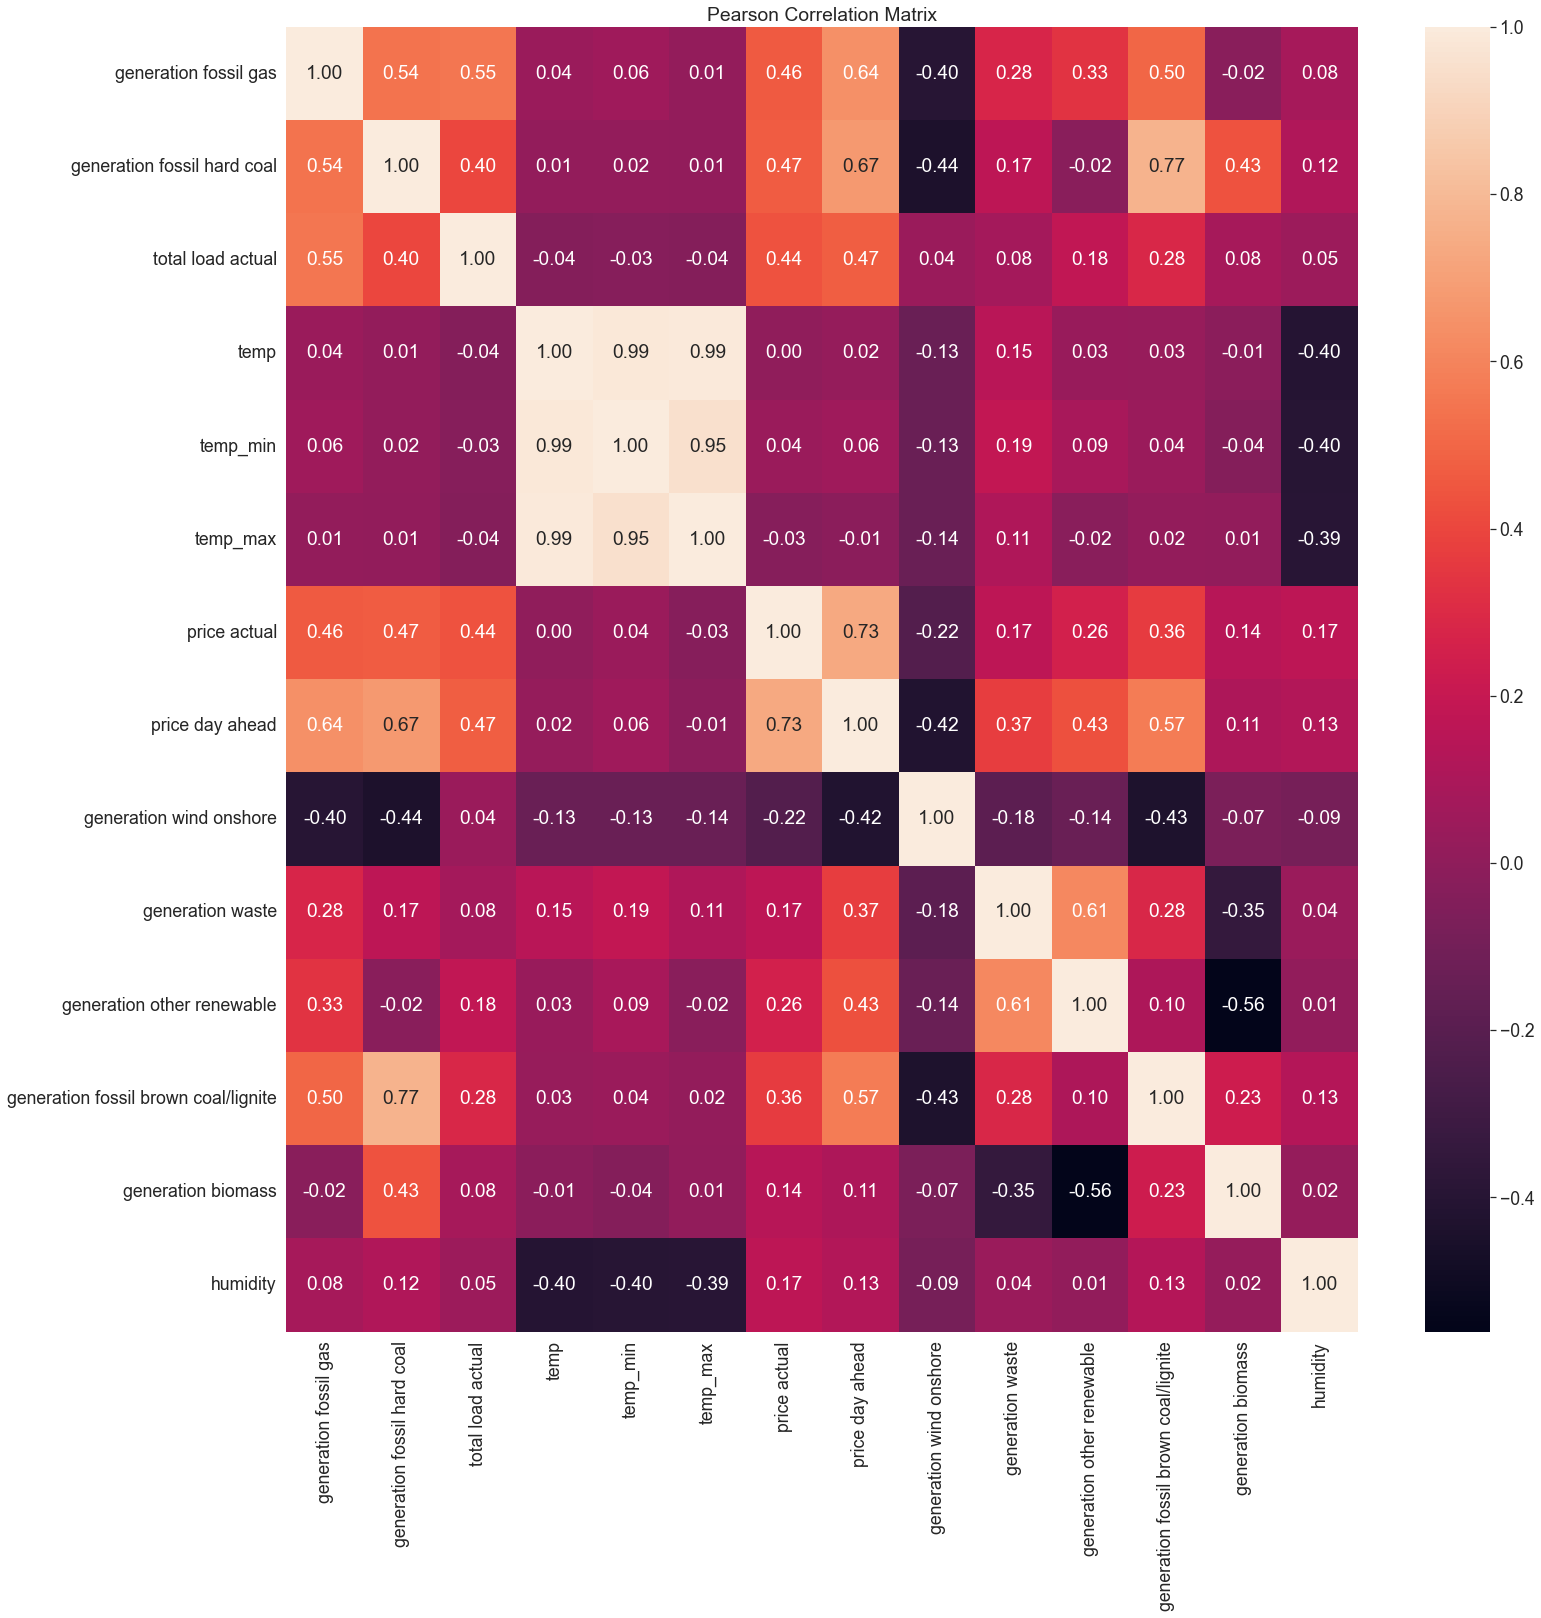

In [ ]:
correlations = valencia_energy_df.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.set(font_scale=1.6)
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [ ]:
predictors = ['temp', 'temp_min', 'temp_max', 'price actual', 'generation wind onshore', 'generation waste', 'generation other renewable', 'generation fossil brown coal/lignite', 'generation biomass', 'humidity']
targets = ['generation fossil gas', 'generation fossil hard coal', 'price day ahead']
final_target = ['total load actual']
all_targets = np.concatenate([targets, final_target])
all_columns = np.concatenate([predictors, targets, final_target])

valencia_energy_df = valencia_energy_df[all_columns].dropna()
valencia_energy_df

,temp,temp_min,temp_max,price actual,generation wind onshore,generation waste,generation other renewable,generation fossil brown coal/lignite,generation biomass,humidity,generation fossil gas,generation fossil hard coal,price day ahead,total load actual
0,270.475,270.475,270.475,65.41,6378.0,196.0,73.0,329.0,447.0,77,4844.0,4821.0,50.10,25385.0
1,270.475,270.475,270.475,64.92,5890.0,195.0,71.0,328.0,449.0,77,5196.0,4755.0,48.10,24382.0
2,269.686,269.686,269.686,64.48,5461.0,196.0,73.0,323.0,448.0,78,4857.0,4581.0,47.33,22734.0
3,269.686,269.686,269.686,59.32,5238.0,191.0,75.0,254.0,438.0,78,4314.0,4131.0,42.27,21286.0
4,269.686,269.686,269.686,56.04,4935.0,189.0,74.0,187.0,428.0,78,4130.0,3840.0,38.41,20264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,282.140,281.150,283.150,77.02,3113.0,277.0,95.0,0.0,297.0,71,7634.0,2628.0,68.85,30653.0
35060,282.150,282.150,282.150,76.16,3288.0,280.0,95.0,0.0,296.0,87,7241.0,2566.0,68.40,29735.0
35061,284.150,284.150,284.150,74.30,3503.0,286.0,94.0,0.0,292.0,76,7025.0,2422.0,66.88,28071.0
35062,285.660,285.150,286.150,69.89,3586.0,287.0,93.0,0.0,293.0,76,6562.0,2293.0,63.93,25801.0


# Step 2. Sampling of chosen target variables using univariate parametric distributions (from practice #2) with 2 different sampling methods

# Inverse Transform sampling

In [ ]:
def inv_trans_sampling_hist(values, num_samples=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
    
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    uniform_values = np.random.rand(num_samples)
    
    return inversed_cdf(uniform_values), n_bins

[4672.55921462 6175.29711498 1232.66493417 ... 9792.75469684 4056.98801452
 2643.1701393 ]
[4918.30306149 3523.4306473  2442.91212958 ... 4720.66969207 1023.26438732
 4714.61448917]
[52.28171439 71.81415487 55.53208981 ... 65.53557325 34.47845925
 64.4181857 ]
[24846.53435002 34184.68932629 34660.07058811 ... 33319.52185178
 33906.71562035 32230.50644676]
{'generation fossil gas': array([4672.55921462, 6175.29711498, 1232.66493417, ..., 9792.75469684,
       4056.98801452, 2643.1701393 ]), 'generation fossil hard coal': array([4918.30306149, 3523.4306473 , 2442.91212958, ..., 4720.66969207,
       1023.26438732, 4714.61448917]), 'price day ahead': array([52.28171439, 71.81415487, 55.53208981, ..., 65.53557325,
       34.47845925, 64.4181857 ]), 'total load actual': array([24846.53435002, 34184.68932629, 34660.07058811, ...,
       33319.52185178, 33906.71562035, 32230.50644676])}


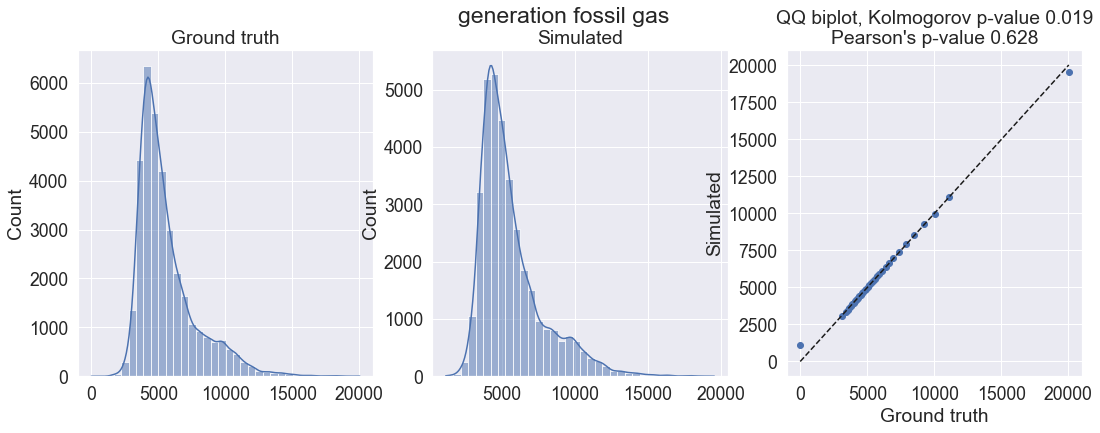

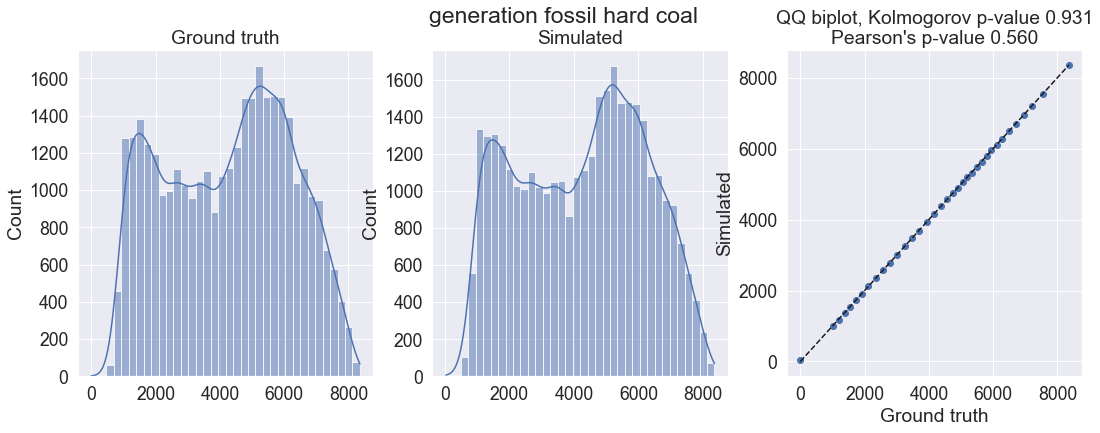

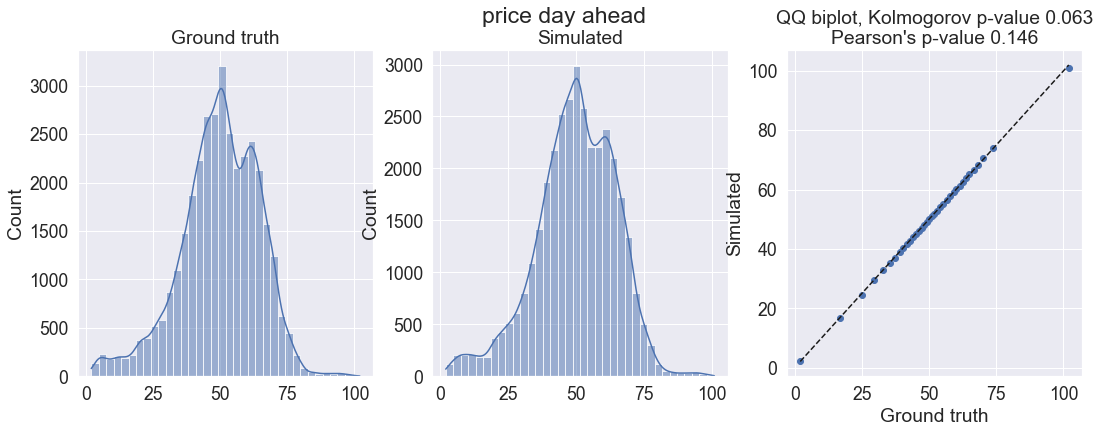

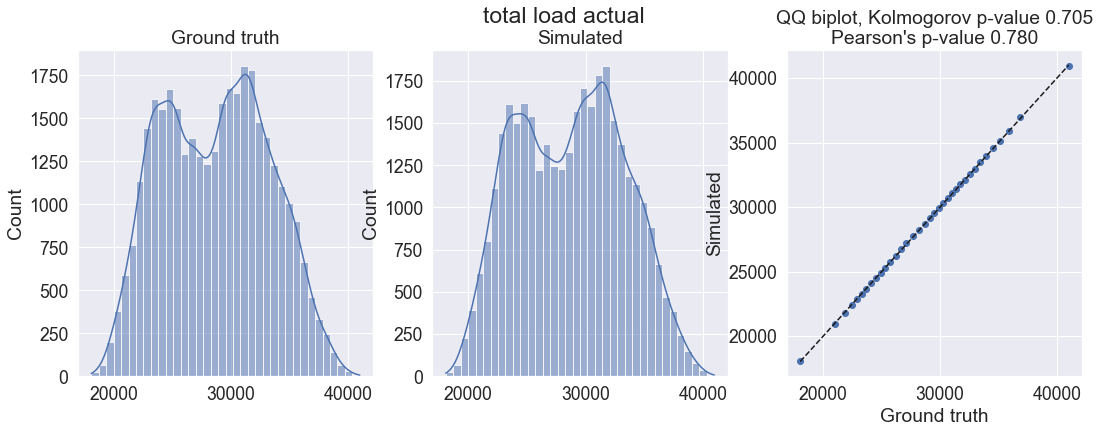

In [ ]:
data = {}


for target_var in all_targets:

    sampled, n_bins = inv_trans_sampling_hist(valencia_energy_df[target_var], 
                                              num_samples=valencia_energy_df.shape[0])
        
    data[target_var] = sampled
    
    ks_stat, ks_pv = scipy.stats.ks_2samp(valencia_energy_df[target_var], sampled)
    
    freqs, bin_edges = np.histogram(valencia_energy_df[target_var], bins=n_bins)
    # Add 1 to all frequencies so that we didn't get 0 in some sampled frequencies
    freqs += 1
    freqs_sampled = np.bincount(np.concatenate([np.digitize(sampled, bin_edges) - 1, 
                                                np.arange(n_bins)]))
    chi_stat, chi_pv = scipy.stats.chisquare(freqs_sampled, freqs)
    
    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(valencia_energy_df[target_var], percs)
    qn_sampled = np.percentile(sampled, percs)

    fig, ax = plt.subplots(ncols=3, figsize=(18, 6), sharex=False, sharey=False)
    
    sns.histplot(valencia_energy_df[target_var], bins=n_bins, kde=True, ax=ax[0])
    ax[0].set_xlabel(None)
    ax[0].set_title("Ground truth")
    
    sns.histplot(sampled, bins=n_bins, kde=True, ax=ax[1])
    ax[1].set_title(f"Simulated")
    
    ax[2].plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    ax[2].plot(qn_gt, qn_gt, color="k", ls="--")
    ax[2].set_xlabel("Ground truth")
    ax[2].set_ylabel("Simulated")
    ax[2].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.3f}\nPearson's p-value {chi_pv:.3f}")
    
    fig.suptitle(f"{target_var}")
    plt.plot();
    
    
sampled_df = pd.DataFrame(data)

In [ ]:
valencia_energy_df[all_targets].mean()

generation fossil gas           5622.700647
generation fossil hard coal     4256.531271
price day ahead                   49.874341
total load actual              28698.281385
dtype: float64

In [ ]:
sampled_df[all_targets].mean()

generation fossil gas           5621.152824
generation fossil hard coal     4248.894343
price day ahead                   49.826884
total load actual              28715.702959
dtype: float64

In [ ]:
valencia_energy_df[all_targets].var()

generation fossil gas          4.846651e+06
generation fossil hard coal    3.849401e+06
price day ahead                2.137122e+02
total load actual              2.093821e+07
dtype: float64

In [ ]:
sampled_df[all_targets].var()

generation fossil gas          4.854246e+06
generation fossil hard coal    3.865596e+06
price day ahead                2.166332e+02
total load actual              2.108210e+07
dtype: float64

# Geometric sampling

In [ ]:
def geom_sampling_hist(values, num_samples=1000, batch_size=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    left, right = np.min(bin_edges), np.max(bin_edges)
    bottom, top = np.min(hist), np.max(hist)
    
    accept_samples = np.asarray([])
    
    while accept_samples.shape[0] < num_samples:
        
        x_sampl = np.random.uniform(left, right, size=(batch_size,))
        y_sampl = np.random.uniform(bottom, top, size=(batch_size,))
        
        x_indices = np.digitize(x_sampl, bin_edges) - 1
        y_mask = (y_sampl <= hist[x_indices])
        
        accept_samples = np.concatenate([accept_samples, x_sampl[y_mask]])
        
    return accept_samples[:num_samples], n_bins

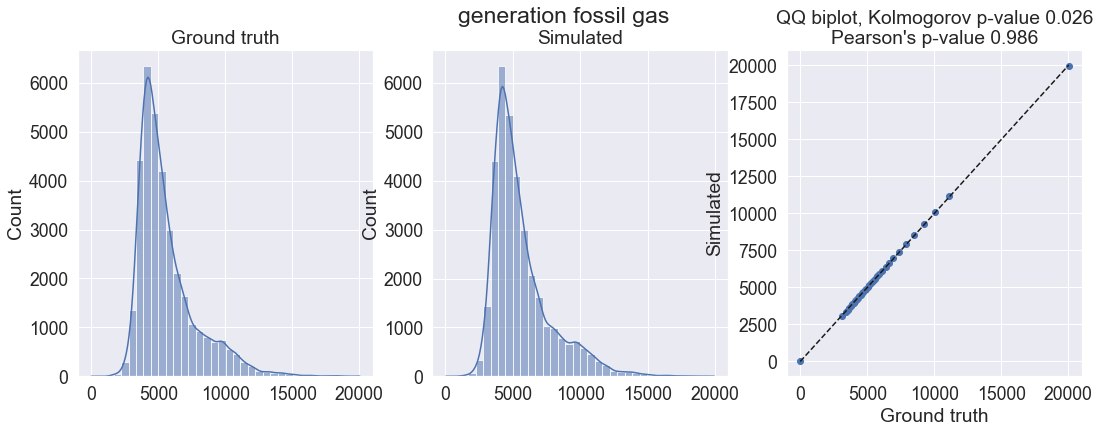

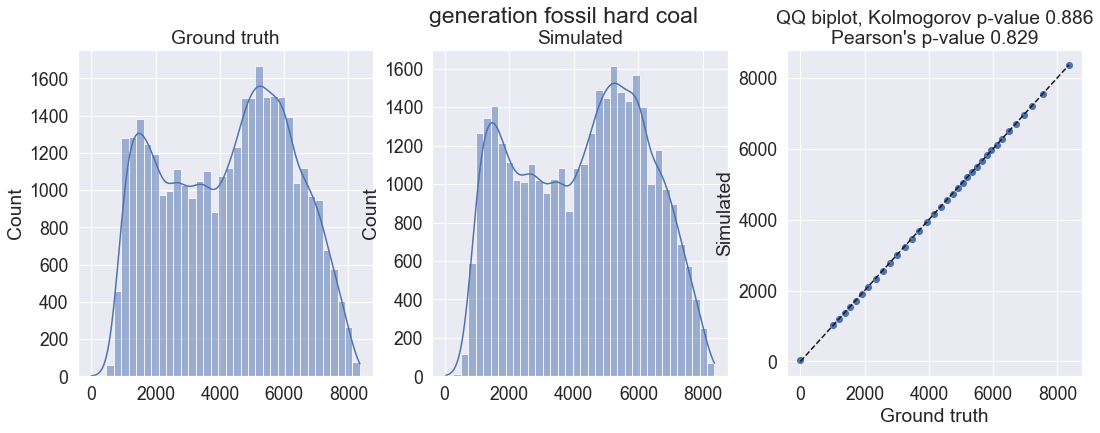

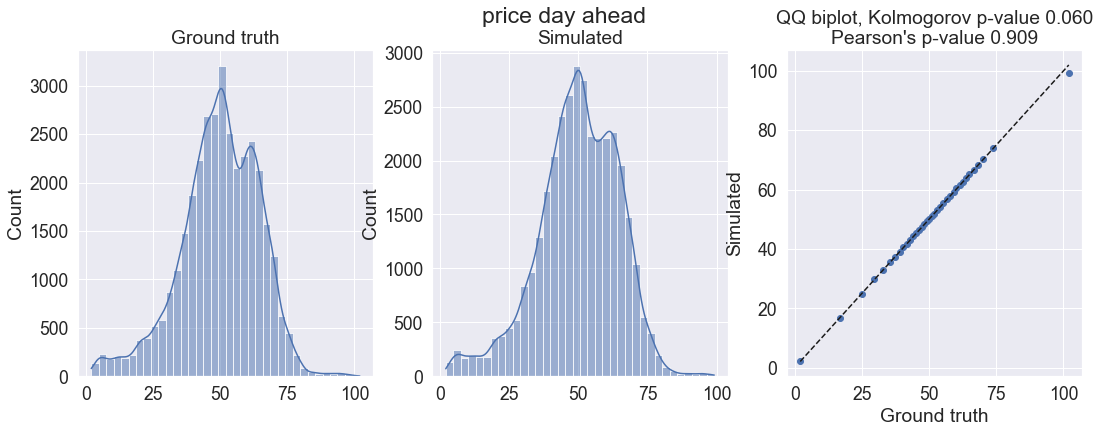

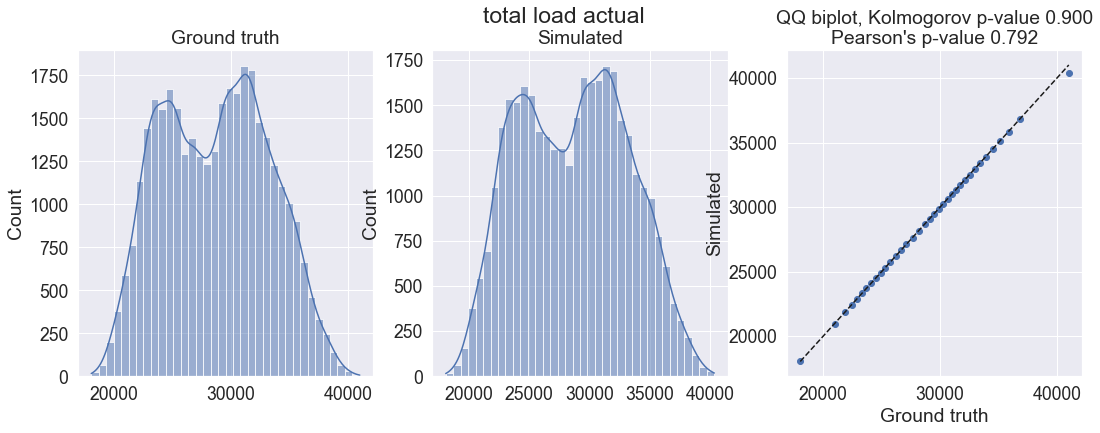

In [ ]:
gs_data = {}


for target_var in all_targets:

    sampled, n_bins = geom_sampling_hist(valencia_energy_df[target_var], 
                                         num_samples=valencia_energy_df.shape[0])
    
    gs_data[target_var] = sampled
    
    ks_stat, ks_pv = scipy.stats.ks_2samp(valencia_energy_df[target_var], sampled)
    
    freqs, bin_edges = np.histogram(valencia_energy_df[target_var], bins=n_bins)
    # Add 1 to all frequencies so that we didn't get 0 in some sampled frequencies
    freqs += 1
    freqs_sampled = np.bincount(np.concatenate([np.digitize(sampled, bin_edges) - 1, np.arange(n_bins)]))
    chi_stat, chi_pv = scipy.stats.chisquare(freqs_sampled, freqs)
    
    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(valencia_energy_df[target_var], percs)
    qn_sampled = np.percentile(sampled, percs)

    fig, ax = plt.subplots(ncols=3, figsize=(18, 6), sharex=False, sharey=False)
    
    sns.histplot(valencia_energy_df[target_var], bins=n_bins, kde=True, ax=ax[0])
    ax[0].set_xlabel(None)
    ax[0].set_title("Ground truth")
    
    sns.histplot(sampled, bins=n_bins, kde=True, ax=ax[1])
    ax[1].set_title(f"Simulated")
    
    ax[2].plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    ax[2].plot(qn_gt, qn_gt, color="k", ls="--")
    ax[2].set_xlabel("Ground truth")
    ax[2].set_ylabel("Simulated")
    ax[2].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.3f}\nPearson's p-value {chi_pv:.3f}")
    
    fig.suptitle(f"{target_var}")
    plt.plot();
    
    
gs_sampled_df = pd.DataFrame(gs_data)

In [ ]:
valencia_energy_df[all_targets].mean()

generation fossil gas           5622.700647
generation fossil hard coal     4256.531271
price day ahead                   49.874341
total load actual              28698.281385
dtype: float64

In [ ]:
gs_sampled_df[all_targets].mean()

generation fossil gas           5624.066966
generation fossil hard coal     4246.766703
price day ahead                   49.958407
total load actual              28686.024691
dtype: float64

In [ ]:
valencia_energy_df[all_targets].var()

generation fossil gas          4.846651e+06
generation fossil hard coal    3.849401e+06
price day ahead                2.137122e+02
total load actual              2.093821e+07
dtype: float64

In [ ]:
gs_sampled_df[all_targets].var()

generation fossil gas          4.907734e+06
generation fossil hard coal    3.868477e+06
price day ahead                2.138334e+02
total load actual              2.071651e+07
dtype: float64

### Inverse & Geometric

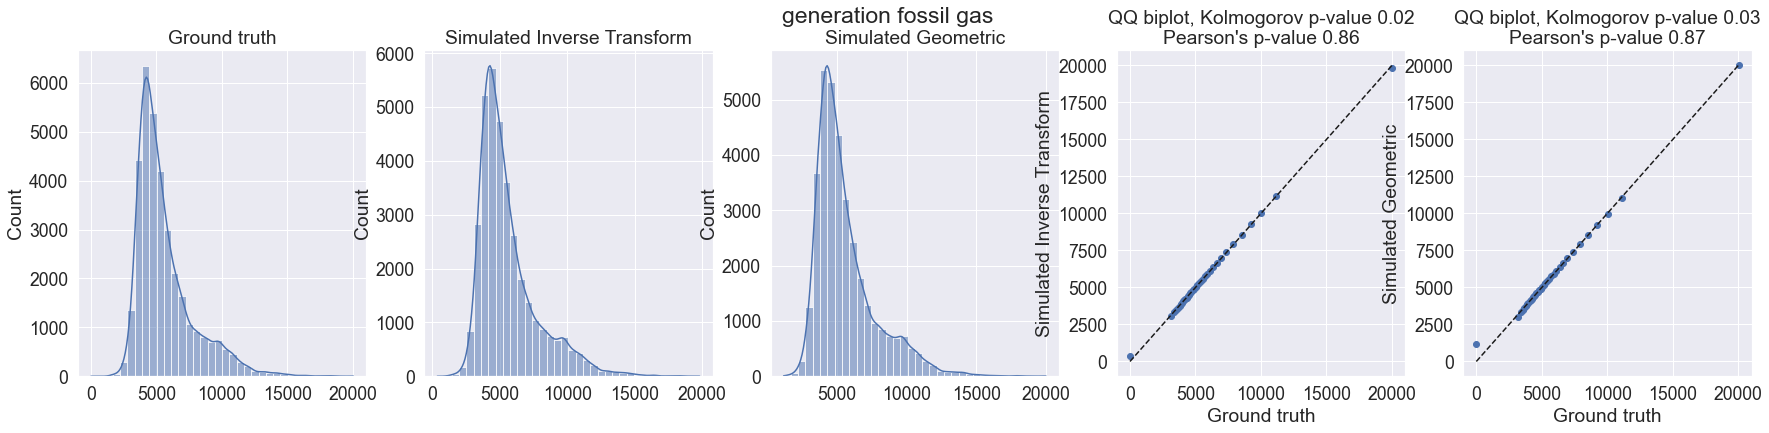

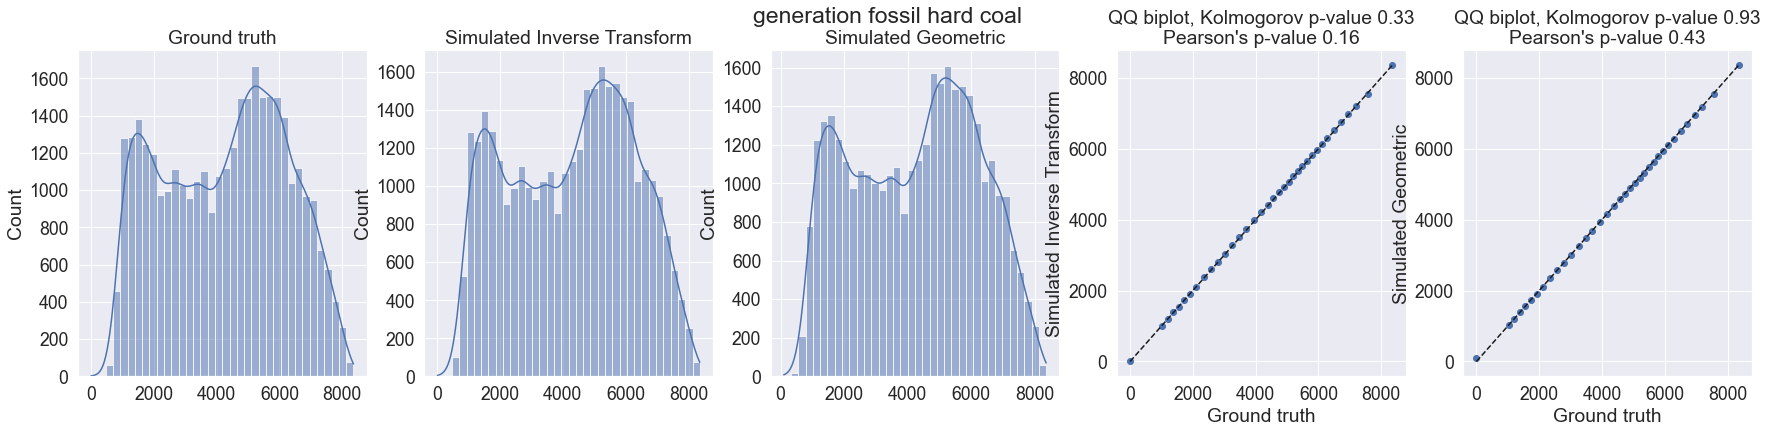

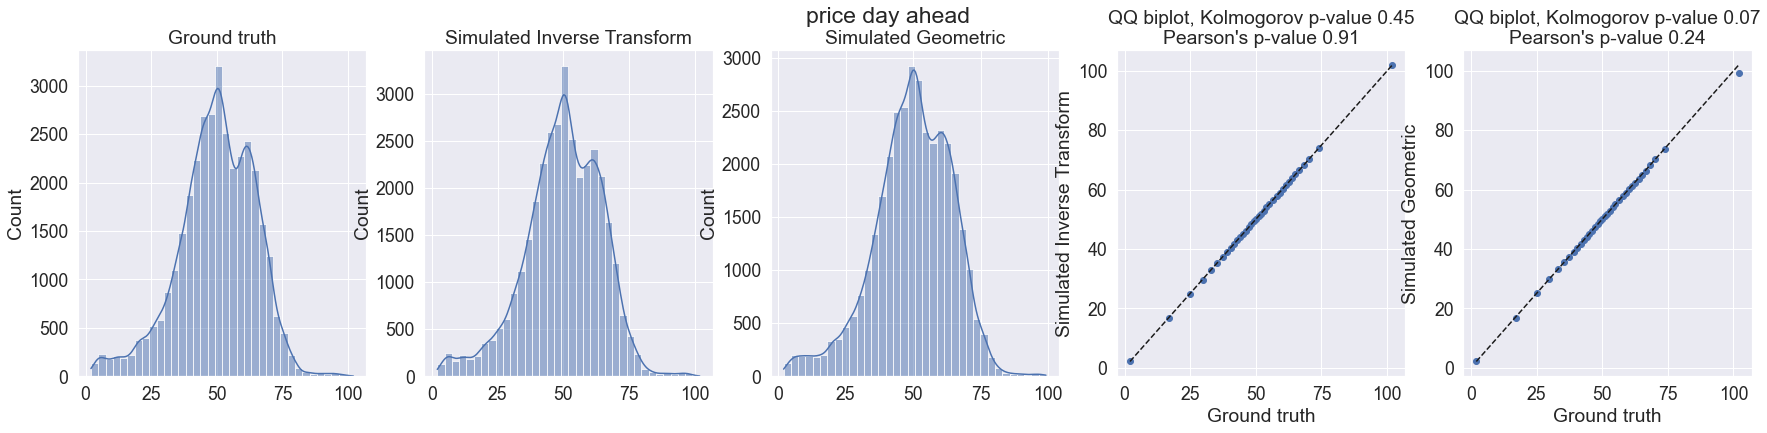

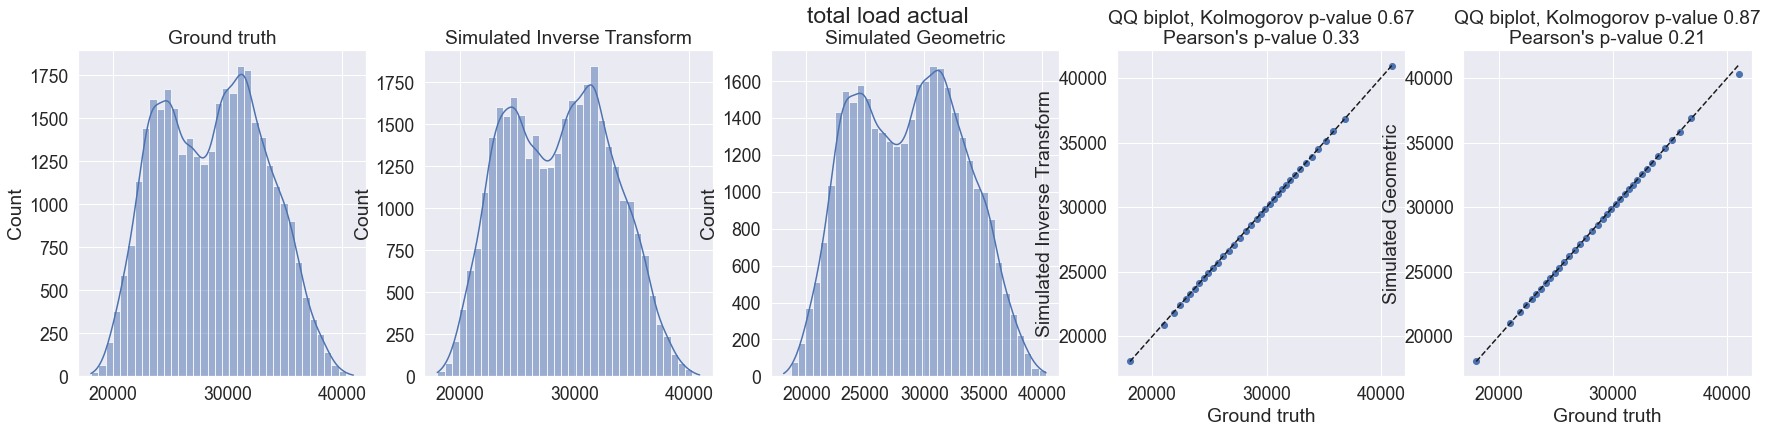

In [ ]:
for target_var in all_targets:

    fig, ax = plt.subplots(ncols=5, figsize=(30, 6), sharex=False, sharey=False)
    
    sampled_inv, n_bins = inv_trans_sampling_hist(valencia_energy_df[target_var], 
                                                  num_samples=valencia_energy_df.shape[0])
    sampled_geom, n_bins = geom_sampling_hist(valencia_energy_df[target_var], 
                                              num_samples=valencia_energy_df.shape[0])
    
    sns.histplot(valencia_energy_df[target_var], bins=n_bins, kde=True, ax=ax[0])
    ax[0].set_xlabel(None)
    ax[0].set_title("Ground truth")
    
    sns.histplot(sampled_inv, bins=n_bins, kde=True, ax=ax[1])
    ax[1].set_title("Simulated Inverse Transform")
    
    sns.histplot(sampled_geom, bins=n_bins, kde=True, ax=ax[2])
    ax[2].set_title("Simulated Geometric")
    
    for idx, sim_name, sampled in zip([3, 4], ["Inverse Transform", "Geometric"], 
                                      [sampled_inv, sampled_geom]):
        ks_stat, ks_pv = scipy.stats.ks_2samp(valencia_energy_df[target_var], sampled)

        freqs, bin_edges = np.histogram(valencia_energy_df[target_var], bins=n_bins)
        # Add 1 to all frequencies so that we didn't get 0 in some sampled frequencies
        freqs += 1
        freqs_sampled = np.bincount(np.concatenate([np.digitize(sampled, bin_edges) - 1, np.arange(n_bins)]))
        chi_stat, chi_pv = scipy.stats.chisquare(freqs_sampled, freqs)

        percs = np.linspace(0, 100, n_bins)
        qn_gt = np.percentile(valencia_energy_df[target_var], percs)
        qn_sampled = np.percentile(sampled, percs)

        ax[idx].plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
        ax[idx].plot(qn_gt, qn_gt, color="k", ls="--")
        ax[idx].set_xlabel("Ground truth")
        ax[idx].set_ylabel(f"Simulated {sim_name}")
        ax[idx].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.2f}\nPearson's p-value {chi_pv:.2f}")
    
    fig.suptitle(f"{target_var}")
    plt.plot();

# Step 3. Estimation of relations between predictors and chosen target variables

/tmp/ipykernel_70024/2417133090.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

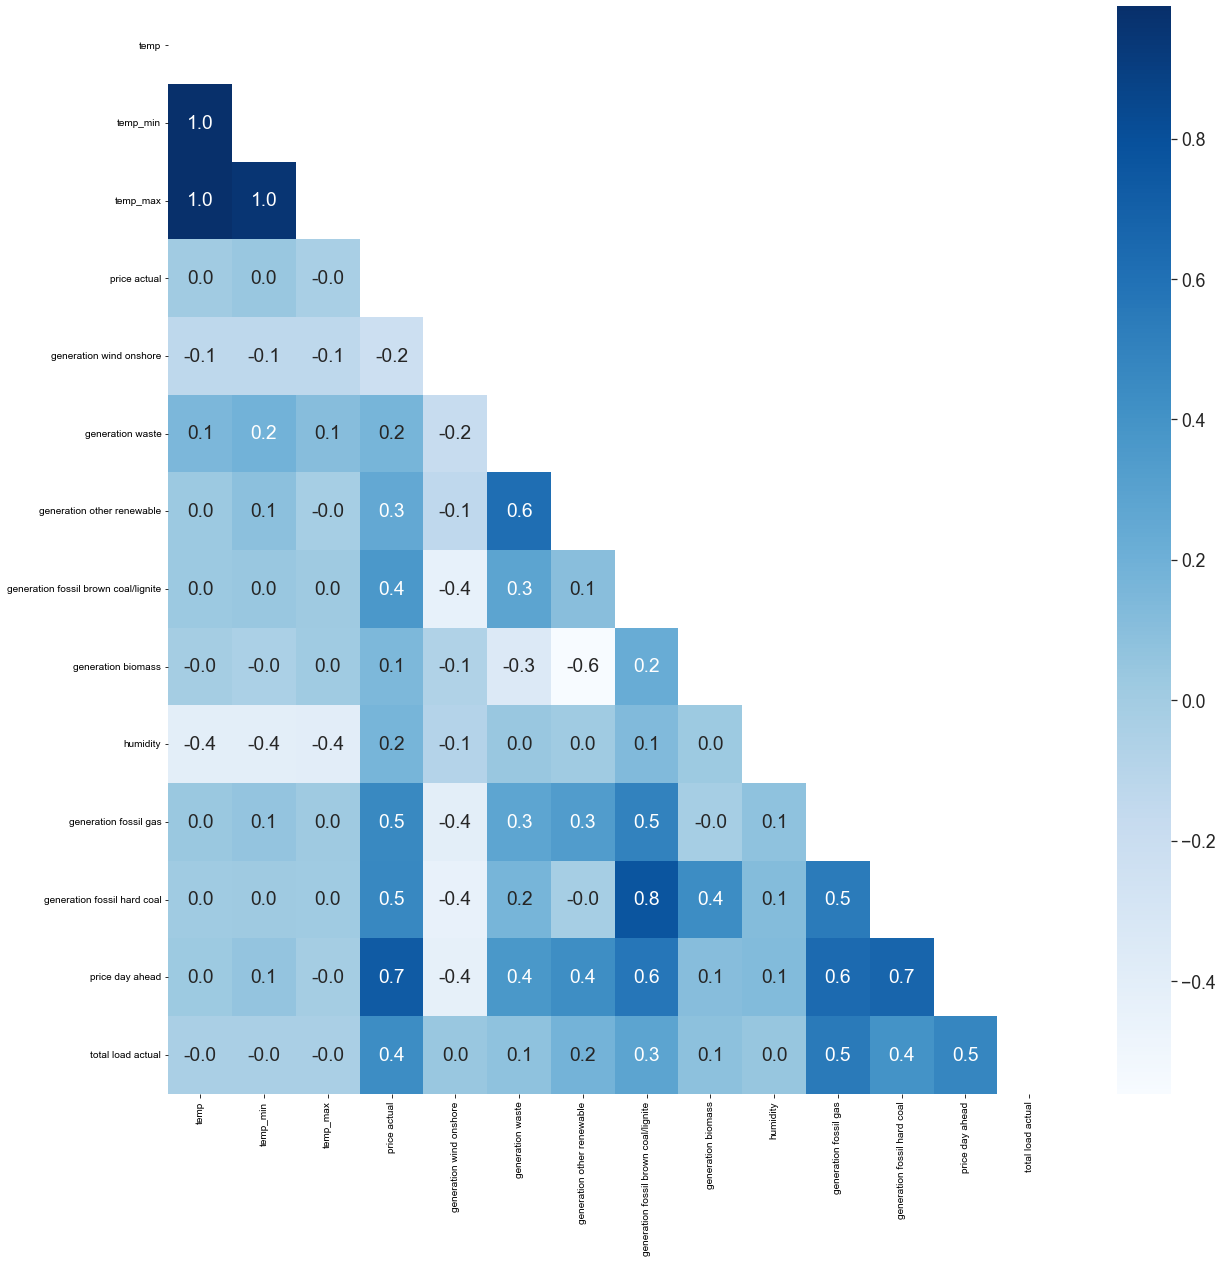

In [ ]:
# Building a correlation matrix of features
corr = valencia_energy_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

sns.set(font_scale=1.6)
sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', ax=ax, cmap='Blues')

# Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm

> #### Scheme of dependencies:
>
>> The main independent variables are 'temp', 'temp_min', 'temp_max', 'price actual', 'total load actual', 'generation wind onshore', 'generation waste', 'generation other renewable', 'generation fossil brown coal/lignite', 'generation biomass', 'generation other'
>
>> **'generation fossil gas'** → 'total load actual', price actual', 'generation wind onshore', 'generation fossil brown coal/lignite'\n
>
>> **'generation fossil hard coal'** → 'price actual','total load actual', 'generation wind onshore', 'generation fossil brown coal/lignite', 'generation biomass', 'generation fossil gas'\n
>
>> **'humidity'** → 'temp', 'temp_min', 'temp_max'\n
>
>> **'price day ahead'** → 'price actual', 'total load actual', 'generation wind onshore', 'generation waste', 'generation other renewable', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal'


In [ ]:
print(valencia_energy_df.columns.tolist())

['temp', 'temp_min', 'temp_max', 'price actual', 'generation wind onshore', 'generation waste', 'generation other renewable', 'generation fossil brown coal/lignite', 'generation biomass', 'humidity', 'generation fossil gas', 'generation fossil hard coal', 'price day ahead', 'total load actual']


In [ ]:
valencia_energy_df.corr()

,temp,temp_min,temp_max,price actual,generation wind onshore,generation waste,generation other renewable,generation fossil brown coal/lignite,generation biomass,humidity,generation fossil gas,generation fossil hard coal,price day ahead,total load actual
temp,1.000000,0.986958,0.988158,0.002393,-0.134393,0.148601,0.032272,0.029165,-0.013912,-0.402792,0.037069,0.012821,0.022618,-0.037044
temp_min,0.986958,1.000000,0.953258,0.040027,-0.134022,0.185518,0.088046,0.042444,-0.042169,-0.401060,0.059901,0.016114,0.059971,-0.034504
temp_max,0.988158,0.953258,1.000000,-0.034044,-0.135248,0.110150,-0.021515,0.016031,0.011779,-0.391841,0.014248,0.009900,-0.014436,-0.039457
price actual,0.002393,0.040027,-0.034044,1.000000,-0.220497,0.168710,0.255551,0.363993,0.142671,0.169634,0.461452,0.465637,0.732155,0.435253
generation wind onshore,-0.134393,-0.134022,-0.135248,-0.220497,1.000000,-0.183434,-0.138296,-0.434172,-0.068687,-0.085469,-0.397305,-0.441756,-0.424892,0.039667
generation waste,0.148601,0.185518,0.110150,0.168710,-0.183434,1.000000,0.614009,0.282885,-0.346040,0.040115,0.275164,0.170285,0.368001,0.076971
generation other renewable,0.032272,0.088046,-0.021515,0.255551,-0.138296,0.614009,1.000000,0.104441,-0.560567,0.010986,0.334858,-0.019534,0.427838,0.180814
generation fossil brown coal/lignite,0.029165,0.042444,0.016031,0.363993,-0.434172,0.282885,0.104441,1.000000,0.230039,0.129350,0.499902,0.768831,0.568159,0.280735
generation biomass,-0.013912,-0.042169,0.011779,0.142671,-0.068687,-0.346040,-0.560567,0.230039,1.000000,0.024524,-0.021520,0.433734,0.109238,0.083507
humidity,-0.402792,-0.401060,-0.391841,0.169634,-0.085469,0.040115,0.010986,0.129350,0.024524,1.000000,0.079725,0.121066,0.126070,0.045430


In [ ]:
valencia_train, valencia_test = train_test_split(valencia_energy_df, test_size=0.2, random_state=42)
valencia_train

,temp,temp_min,temp_max,price actual,generation wind onshore,generation waste,generation other renewable,generation fossil brown coal/lignite,generation biomass,humidity,generation fossil gas,generation fossil hard coal,price day ahead,total load actual
14233,300.610,299.750,302.040,52.75,3496.0,321.0,68.0,42.0,381.0,38,4830.0,2694.0,46.35,22771.0
29000,292.150,292.150,292.150,62.29,2391.0,288.0,89.0,0.0,298.0,59,5531.0,2202.0,54.50,29917.0
11074,286.750,285.350,287.750,42.19,1345.0,242.0,84.0,0.0,324.0,82,4328.0,1885.0,38.38,28364.0
616,287.450,287.450,287.450,74.44,5437.0,233.0,74.0,965.0,466.0,31,5385.0,7563.0,62.75,34395.0
19057,282.150,282.150,282.150,38.32,3191.0,319.0,94.0,500.0,238.0,100,4315.0,4600.0,43.81,23547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,286.150,286.150,286.150,58.05,6940.0,209.0,66.0,0.0,451.0,82,3329.0,1379.0,25.69,24512.0
6265,296.590,295.930,298.150,51.11,4466.0,262.0,70.0,297.0,556.0,41,4252.0,4541.0,42.50,22298.0
11284,290.300,287.150,291.850,28.08,1782.0,220.0,76.0,0.0,206.0,62,3882.0,1249.0,21.08,23264.0
860,279.350,279.350,279.350,79.39,7175.0,154.0,71.0,0.0,406.0,34,4548.0,2727.0,46.39,25006.0


In [ ]:
nodes_type = get_nodes_type(valencia_train)
nodes_type

{'temp': 'cont',
 'temp_min': 'cont',
 'temp_max': 'cont',
 'price actual': 'cont',
 'generation wind onshore': 'cont',
 'generation waste': 'cont',
 'generation other renewable': 'cont',
 'generation fossil brown coal/lignite': 'cont',
 'generation biomass': 'cont',
 'humidity': 'disc',
 'generation fossil gas': 'cont',
 'generation fossil hard coal': 'cont',
 'price day ahead': 'cont',
 'total load actual': 'cont'}

In [ ]:
nodes_sign = get_nodes_sign(valencia_train)
nodes_sign

{'temp': 'pos',
 'temp_min': 'pos',
 'temp_max': 'pos',
 'price actual': 'pos',
 'generation wind onshore': 'pos',
 'generation waste': 'pos',
 'generation other renewable': 'pos',
 'generation fossil brown coal/lignite': 'pos',
 'generation biomass': 'pos',
 'generation fossil gas': 'pos',
 'generation fossil hard coal': 'pos',
 'price day ahead': 'pos',
 'total load actual': 'pos'}

### Hand-created network

In [ ]:
valencia_bn = dict( 
    {'V': ['temp',
          'temp_min',
          'temp_max',
          'price actual',
          'generation wind onshore',
          'generation waste',
          'generation other renewable',
          'generation fossil brown coal/lignite',
          'generation biomass',
          'humidity',
          'generation fossil gas',
          'generation fossil hard coal',
          'price day ahead',
          'total load actual'],
     'E': [['humidity', 'temp'],
          ['humidity', 'temp_min'],
          ['humidity', 'temp_max'],
          ['price actual', 'generation fossil gas'],
          ['price actual', 'generation fossil hard coal'],
          ['price actual', 'price day ahead'],
          ['generation fossil hard coal', 'generation fossil brown coal/lignite'],
          ['generation fossil hard coal', 'generation wind onshore'],
          ['generation fossil hard coal', 'total load actual'],
          ['generation fossil hard coal', 'generation biomass'],
          ['generation fossil gas', 'generation fossil brown coal/lignite'],
          ['generation fossil gas', 'generation wind onshore'],
          ['generation fossil gas', 'total load actual'],
          ['price day ahead', 'total load actual'],
          ['price day ahead', 'generation wind onshore'],
          ['price day ahead', 'generation waste'],
          ['price day ahead', 'generation other renewable'],
          ['price day ahead', 'generation fossil brown coal/lignite']]
    }
)

Transformation from continuous to discrete

In [ ]:
draw_BN(valencia_bn, nodes_type, 'valencia_energy_bn')

In [ ]:
params = parameter_learning(valencia_train, nodes_type, valencia_bn, 'simple')
save_structure(valencia_bn, 's&p_bayes_manual_structure')
skel = read_structure('s&p_bayes_manual_structure')
save_params(params, 's&p_bayes_manual_params')
params = read_params('s&p_bayes_manual_params')
valencia_bn = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(valencia_bn, nodes_sign, 'simple', 800)

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'generation fossil gas': 1934.36})


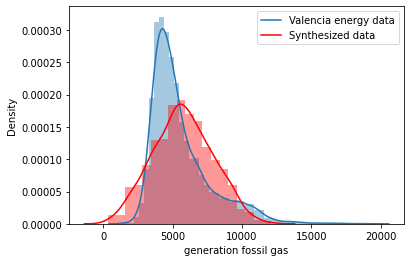

In [ ]:
sns.distplot(valencia_test['generation fossil gas'])
sns.distplot(synth_df['generation fossil gas'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn, valencia_test, ['generation fossil gas'], 'simple')[0:2])

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'price day ahead': 10.107})


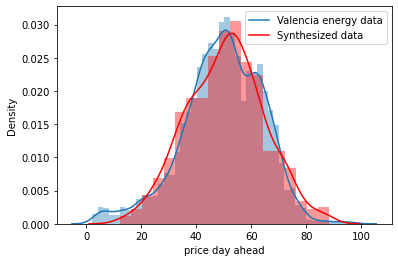

In [ ]:
sns.distplot(valencia_test['price day ahead'])
sns.distplot(synth_df['price day ahead'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn, valencia_test, ['price day ahead'], 'simple')[0:2])

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'generation fossil hard coal': 1760.296})


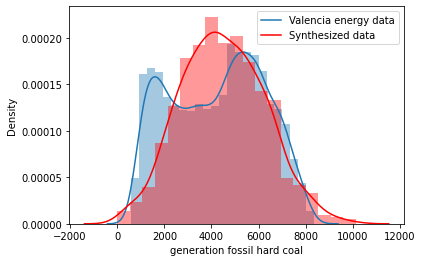

In [ ]:
sns.distplot(valencia_test['generation fossil hard coal'])
sns.distplot(synth_df['generation fossil hard coal'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn, valencia_test, ['generation fossil hard coal'], 'simple')[0:2])

> # Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning
> # Step 6. Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation)

### Hill Climb algorithm 

In [ ]:
coded_data, coder = code_categories(valencia_train, 'label', ['humidity'])

In [ ]:
discrete_data, coder = discretization(coded_data, 'equal_frequency', ['generation fossil gas', 'generation fossil hard coal', 'total load actual', 'temp', 'temp_min', 'temp_max', 'price actual', 'price day ahead', 'generation wind onshore', 'generation waste', 'generation other renewable', 'generation fossil brown coal/lignite', 'generation biomass'])

/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:236: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
valencia_bn_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
valencia_bn_hc

{'V': ['temp',
  'temp_min',
  'temp_max',
  'price actual',
  'generation wind onshore',
  'generation waste',
  'generation other renewable',
  'generation fossil brown coal/lignite',
  'generation biomass',
  'humidity',
  'generation fossil gas',
  'generation fossil hard coal',
  'price day ahead',
  'total load actual'],
 'E': [['temp', 'temp_min'],
  ['temp_min', 'generation fossil brown coal/lignite'],
  ['temp_min', 'generation other renewable'],
  ['temp_min', 'generation biomass'],
  ['temp_max', 'temp'],
  ['temp_max', 'generation other renewable'],
  ['temp_max', 'temp_min'],
  ['temp_max', 'generation fossil hard coal'],
  ['temp_max', 'generation biomass'],
  ['price actual', 'total load actual'],
  ['generation waste', 'price actual'],
  ['generation waste', 'price day ahead'],
  ['generation other renewable', 'generation biomass'],
  ['generation other renewable', 'generation waste'],
  ['generation other renewable', 'price day ahead'],
  ['generation other renewable',

In [ ]:
draw_BN(valencia_bn_hc, nodes_type, 'valencia_energy_bn_hc')

In [ ]:
params = parameter_learning(valencia_train, nodes_type, valencia_bn_hc, 'simple')

save_structure(valencia_bn_hc, 'valencia_net_structure')
skel = read_structure('valencia_net_structure')
save_params(params, 'valencia_net_structure')
params = read_params('valencia_net_structure')
valencia_bn_hc = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(valencia_bn_hc, nodes_sign, 'simple', 1000)

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'generation fossil gas': 1585.662})


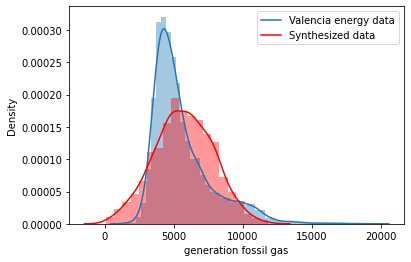

In [ ]:
sns.distplot(valencia_test['generation fossil gas'])
sns.distplot(synth_df['generation fossil gas'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn_hc, valencia_test, ['generation fossil gas'], 'simple')[0:2])

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'price day ahead': 8.592})


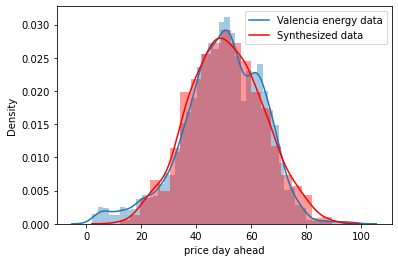

In [ ]:
sns.distplot(valencia_test['price day ahead'])
sns.distplot(synth_df['price day ahead'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn_hc, valencia_test, ['price day ahead'], 'simple')[0:2])

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'generation fossil hard coal': 1129.271})


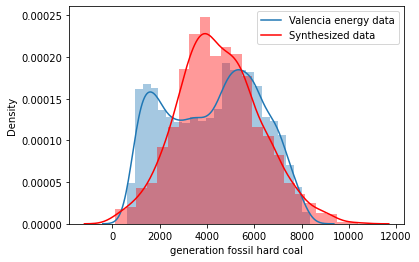

In [ ]:
sns.distplot(valencia_test['generation fossil hard coal'])
sns.distplot(synth_df['generation fossil hard coal'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn_hc, valencia_test, ['generation fossil hard coal'], 'simple')[0:2])

### Hill Climb (mix)

In [ ]:
# params = parameter_learning(valencia_train, nodes_type, valencia_bn_hc, 'mix')

# save_structure(valencia_bn_hc, 'valencia_net_structure')
# skel = read_structure('valencia_net_structure')
# save_params(params, 'valencia_net_structure')
# params = read_params('valencia_net_structure')
# valencia_bn_hc = HyBayesianNetwork(skel, params)
# synth_df = generate_synthetics(valencia_bn_hc, nodes_sign, 'mix', 1000)

In [ ]:
# sns.distplot(valencia_test['generation fossil gas'])
# sns.distplot(synth_df['generation fossil gas'], color="r")
# plt.legend(['Valencia energy data', 'Synthesized data'])

# print(calculate_acc(valencia_bn_hc, valencia_test, ['generation fossil gas'], 'mix')[0:2])

In [ ]:
# sns.distplot(valencia_test['price day ahead'])
# sns.distplot(synth_df['price day ahead'], color="r")
# plt.legend(['Valencia energy data', 'Synthesized data'])

# print(calculate_acc(valencia_bn_hc, valencia_test, ['price day ahead'], 'mix')[0:2])

In [ ]:
# sns.distplot(valencia_test['generation fossil hard coal'])
# sns.distplot(synth_df['generation fossil hard coal'], color="r")
# plt.legend(['Valencia energy data', 'Synthesized data'])

# print(calculate_acc(valencia_bn_hc, valencia_test, ['generation fossil hard coal'], 'mix')[0:2])

# Evo algorithm

In [ ]:
valencia_bn_evo = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
valencia_bn_evo


/home/aidar/anaconda3/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


Best metric is 17.270400000000006
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.7 min
Best metric is 17.210700000000003
Generation num: 1
max_depth: 6, no improvements: 0
spent time: 1.2 min
Best metric is 17.169700000000002
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 1.8 min
Best metric is 17.160100000000003
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 2.3 min
Best metric is 17.160100000000003
Generation num: 4
max_depth: 6, no improvements: 1
spent time: 2.8 min
Best metric is 17.160100000000003
Generation num: 5
max_depth: 6, no improvements: 2
spent time: 3.4 min
Best metric is 17.160100000000003
Generation num: 6
max_depth: 6, no improvements: 3
spent time: 3.9 min
Best metric is 17.115500000000004
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 4.4 min
Best metric is 17.115500000000004
Generation num: 8
max_depth: 6, no improvements: 1
spent time: 4.9 min
Best metric is 17.105500000000003
Generation num: 9
max

{'V': ['temp',
  'temp_min',
  'temp_max',
  'price actual',
  'generation wind onshore',
  'generation waste',
  'generation other renewable',
  'generation fossil brown coal/lignite',
  'generation biomass',
  'humidity',
  'generation fossil gas',
  'generation fossil hard coal',
  'price day ahead',
  'total load actual'],
 'E': [['price actual', 'generation biomass'],
  ['temp', 'generation fossil brown coal/lignite'],
  ['generation other renewable', 'temp'],
  ['generation fossil brown coal/lignite', 'generation biomass'],
  ['temp_max', 'price actual'],
  ['temp_max', 'temp'],
  ['generation waste', 'price actual'],
  ['generation fossil hard coal', 'generation biomass'],
  ['generation fossil hard coal', 'temp_max'],
  ['humidity', 'price actual'],
  ['humidity', 'temp'],
  ['humidity', 'generation fossil brown coal/lignite'],
  ['humidity', 'temp_max'],
  ['generation wind onshore', 'temp_max'],
  ['temp_min', 'generation fossil brown coal/lignite'],
  ['temp_min', 'temp_max'

In [ ]:
draw_BN(valencia_bn_evo, nodes_type, 'energy_bn_evo')

In [ ]:
params = parameter_learning(valencia_train, nodes_type, valencia_bn_evo, 'simple')
save_structure(valencia_bn_evo, 'valencia_net_structure')
skel = read_structure('valencia_net_structure')
save_params(params, 'valencia_net_structure')
params = read_params('valencia_net_structure')
valencia_bn_evo = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(valencia_bn_evo, nodes_sign, 'simple', 1000)

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'generation fossil gas': 2185.598})


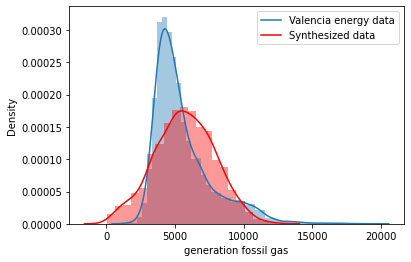

In [ ]:
sns.distplot(valencia_test['generation fossil gas'])
sns.distplot(synth_df['generation fossil gas'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn_evo, valencia_test, ['generation fossil gas'], 'simple')[0:2])

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'price day ahead': 14.606})


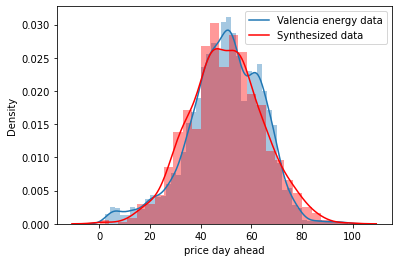

In [ ]:
sns.distplot(valencia_test['price day ahead'])
sns.distplot(synth_df['price day ahead'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn_evo, valencia_test, ['price day ahead'], 'simple')[0:2])

/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aidar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({}, {'generation fossil hard coal': 1976.951})


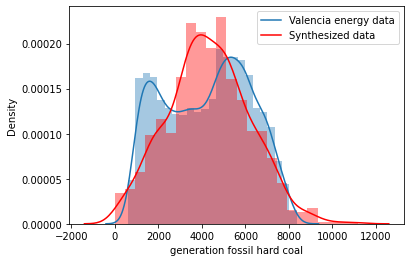

In [ ]:
sns.distplot(valencia_test['generation fossil hard coal'])
sns.distplot(synth_df['generation fossil hard coal'], color="r")
plt.legend(['Valencia energy data', 'Synthesized data'])

print(calculate_acc(valencia_bn_evo, valencia_test, ['generation fossil hard coal'], 'simple')[0:2])

### Evo (mix)

In [ ]:
# params = parameter_learning(valencia_train, nodes_type, valencia_bn_evo, 'mix')
# save_structure(valencia_bn_evo, 'valencia_net_structure')
# skel = read_structure('valencia_net_structure')
# save_params(params, 'valencia_net_structure')
# params = read_params('valencia_net_structure')
# valencia_bn_evo = HyBayesianNetwork(skel, params)
# synth_df = generate_synthetics(valencia_bn_evo, nodes_sign, 'mix', 1000)

In [ ]:
# sns.distplot(valencia_test['generation fossil gas'])
# sns.distplot(synth_df['generation fossil gas'], color="r")
# plt.legend(['Valencia energy data', 'Synthesized data'])

# print(calculate_acc(valencia_bn_evo, valencia_test, ['generation fossil gas'], 'mix')[0:2])

In [ ]:
# sns.distplot(valencia_test['price day ahead'])
# sns.distplot(synth_df['price day ahead'], color="r")
# plt.legend(['Valencia energy data', 'Synthesized data'])

# print(calculate_acc(valencia_bn_evo, valencia_test, ['price day ahead'], 'mix')[0:2])

In [ ]:
# sns.distplot(valencia_test['generation fossil hard coal'])
# sns.distplot(synth_df['generation fossil hard coal'], color="r")
# plt.legend(['Valencia energy data', 'Synthesized data'])

# print(calculate_acc(valencia_bn_evo, valencia_test, ['generation fossil hard coal'], 'mix')[0:2])